In [52]:
%matplotlib inline
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [7]:
train = MNIST(root='data/', download=True)
test = MNIST(root='data/', train=False)

In [8]:
len(train), len(test)

(60000, 10000)

In [11]:
train[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F84A5872A10>, 5)

Label: 5


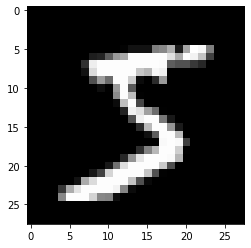

In [14]:
image, label = train[0]
plt.imshow(image, cmap='gray')
print("Label:", label)

In [18]:
train = MNIST(root='data/', download=True, transform=transforms.ToTensor())
test = MNIST(root='data/', train=False, transform=transforms.ToTensor())

In [76]:
img_tensor, label = train[0]
img_tensor.shape, label

(torch.Size([1, 28, 28]), 5)

In [29]:
def split_indices(n, test_size=0.1):
    n_test = int(n * test_size)
    random_indices = np.random.permutation(n)
    return random_indices[n_test:], random_indices[:n_test]  #train-indices and test-indices

In [30]:
train_indices, test_indices = split_indices(len(train), test_size=0.2)
len(train_indices), len(test_indices)

(48000, 12000)

In [43]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dl = DataLoader(train, batch_size, sampler=train_sampler)
test_dl = DataLoader(test, batch_size, sampler=test_sampler)

In [33]:
num_features = 28 * 28
num_classes = 10
model = nn.Linear(num_features, num_classes)
model.weight.shape, model.bias.shape

(torch.Size([10, 784]), torch.Size([10]))

In [49]:
class MnistModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.linear = nn.Linear(num_features, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 28*28)
        out = self.linear(xb)
        return out

model = MnistModel(num_features, num_classes)

In [77]:
for xb, yb in train_dl:
    outputs = model(xb)
    print(out[:2])
    labels = yb
    break

tensor([[ 0.3302, -0.1404, -0.1865, -0.1452, -0.0203,  0.2366,  0.0184, -0.0477,
          0.0723,  0.0614],
        [-0.0878,  0.0373, -0.0546,  0.0845,  0.0213,  0.0093, -0.1112,  0.1489,
         -0.0006,  0.1141]], grad_fn=<SliceBackward>)


In [64]:
probs = F.softmax(outputs, dim=1)
print(probs[:2])

print("Sum: ", torch.sum(probs[0]).item())

tensor([[0.1045, 0.1024, 0.1288, 0.0987, 0.0787, 0.1076, 0.0984, 0.1098, 0.0871,
         0.0840],
        [0.0837, 0.1077, 0.1009, 0.1221, 0.1045, 0.0898, 0.0886, 0.0719, 0.0970,
         0.1339]], grad_fn=<SliceBackward>)
Sum:  1.0000001192092896


In [67]:
max_probs, preds = torch.max(probs, dim=1)
preds, max_probs

(tensor([2, 9, 2, 5, 4, 2, 5, 0, 5, 3, 0, 7, 0, 2, 7, 0, 5, 9, 2, 5, 0, 5, 2, 5,
         7, 0, 5, 7, 0, 2, 6, 5, 9, 7, 2, 5, 0, 0, 2, 9, 5, 3, 5, 5, 0, 2, 0, 5,
         5, 3, 0, 7, 3, 5, 0, 4, 2, 0, 0, 1, 5, 5, 9, 7, 3, 0, 3, 5, 0, 5, 2, 5,
         0, 7, 1, 9, 2, 4, 5, 3, 7, 4, 5, 4, 2, 2, 7, 0, 5, 5, 2, 1, 6, 5, 2, 2,
         7, 0, 5, 7]),
 tensor([0.1288, 0.1339, 0.1547, 0.1285, 0.1151, 0.1245, 0.1439, 0.1167, 0.1303,
         0.1146, 0.1384, 0.1319, 0.1250, 0.1507, 0.1345, 0.1405, 0.1332, 0.1134,
         0.1437, 0.1331, 0.1297, 0.1473, 0.1372, 0.1206, 0.1220, 0.1596, 0.1217,
         0.1099, 0.1219, 0.1835, 0.1236, 0.1247, 0.1129, 0.1358, 0.1391, 0.1226,
         0.1251, 0.1264, 0.1816, 0.1231, 0.1314, 0.1293, 0.1479, 0.1192, 0.1327,
         0.1293, 0.1312, 0.1396, 0.1411, 0.1153, 0.1177, 0.1188, 0.1351, 0.1303,
         0.1278, 0.1177, 0.1385, 0.1146, 0.1783, 0.1291, 0.1218, 0.1229, 0.1216,
         0.1276, 0.1422, 0.1486, 0.1189, 0.1144, 0.1141, 0.1294, 0.1214, 0.1247,
     

In [80]:
def accuracy(ypred, ytest):
    return torch.sum(ypred == ytest).item() / len(ypred)
accuracy(preds, labels)

0.09

In [81]:
loss_fn = F.cross_entropy
loss = loss_fn(outputs, labels)
loss

tensor(2.3190, grad_fn=<NllLossBackward>)

In [82]:
lr = 0.001
opt = torch.optim.SGD(model.parameters(), lr=lr)

In [85]:
def loss_batch(model, loss_func, xb, yb, optimizer=None, metric=None):
    ypred = model(xb)
    loss = loss_func(ypred, yb)
    if opimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if metric is not None:
        result = metric(ypred, yb)
    return loss.item(), len(xb), result